In [ ]:
!pip install --quiet cirq
!pip install --quiet bayesian-optimization

     |████████████████████████████████| 1.6MB 6.7MB/s 


In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
import cirq
from cirq.contrib.svg import SVGCircuit
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import sympy
from time import time

# Define the qubits and the simulator



In [ ]:
x, a, y, b = cirq.GridQubit.rect(1, 4)

qubits = (x, a, y, b)
print(qubits)

quant_simulator = cirq.Simulator()

(cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3))


## Plotting utility

In [ ]:
def plot_target(optimizer, init_p, iter, c: int = 20, smooth: bool = False):
    targets = [r["target"] for r in optimizer.res]
    assert len(targets) == init_p + iter
    plt.figure(figsize=(12,8))
    plt.title("Convergence of BO")
    plt.xlabel("Num. iter.")
    plt.ylabel("Target value")
    plt.ylim(-0.05, 1.05)
    plt.hlines(y=0.75, xmin=0, xmax=len(targets), linestyles='dashed', label='Classical limit', colors='g')
    plt.hlines(y=0.853, xmin=0, xmax=len(targets), linestyles='dashed', label='Quantum limit', colors='cyan')
    plt.plot(range(init_p-1, init_p + iter), targets[init_p-1:], linewidth=0.5, c='b', marker='.', markersize=5)
    plt.plot(range(0, init_p), targets[:init_p], c='r', linewidth=0.5, marker='.', markersize=5)
    if smooth:
        plt.plot(range(0, init_p + iter), savgol_filter(targets, 31, 3), linewidth=2, c='black')
    plt.legend()
    plt.grid(linestyle='dotted')
    plt.show()

# Circuit definitions

We'll try to "win" the CHSH game as proposed by Mark Wilde in his [book](http://www.markwilde.com/qit-notes.pdf) at **Section 3.6.2 : Entanglement in the CHSH Game**.

Another reference for this: Ronald de Wolf's [lecture notes](https://homepages.cwi.nl/~rdewolf/qcnotes.pdf) at **Section 15.2: CHSH: Clauser-Horne-Shimony-Holt**.

*Our goal is to show that entanglement-based strategies can do things that local realist strategies cannot*.

## Entangling: off

In this first example we'll be looking for a way to beat the CHSH game without the possibility of generating entanglement between the qubits.

First of all we have to build our circuit. Qubits $|x\rangle$ and $|y\rangle$ will be our "coins": $|x\rangle = H |0\rangle$ and $|y\rangle = H|0\rangle$.

Qubits $|a\rangle$ and $|b\rangle$ will be built through a parametrized evolution that (hopefully) will be capable of expressing any possible (pure) state: $|a\rangle = \mathcal{U}(\theta) |0\rangle$ and $|b\rangle = \mathcal{U}(\theta) |0\rangle$

Following https://arxiv.org/abs/1905.10876 (Fig. 1) we see that the Hadamard gate followed by two rotations, $R_Z$ and $R_X$ show a decent expressibility.

<p align="center">
  <img src="https://raw.githubusercontent.com/w00zie/pqc_chsh/main/img/expressibility.png" width="800" height="300"/>
</p>


Let's construct $|a\rangle$ and $|b\rangle$ by stacking three layers of these gates:

In [ ]:
def build_vqc_no_ent(qubits, symbols, add_measurement=False):
    (x, a, y, b) = qubits
    circ = cirq.Circuit()
    circ.append([cirq.H(x), cirq.H(y)])
    # Layer 1
    circ.append([cirq.H(a), cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[0])(a), 
                 cirq.rz(symbols[1])(b)])
    circ.append([cirq.rx(symbols[2])(a), 
                 cirq.rx(symbols[3])(b)])
    # Layer 2
    circ.append([cirq.H(a), cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[4])(a), 
                 cirq.rz(symbols[5])(b)])
    circ.append([cirq.rx(symbols[6])(a), 
                 cirq.rx(symbols[7])(b)])
    # Layer 3
    circ.append([cirq.H(a), cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[8])(a), 
                 cirq.rz(symbols[9])(b)])
    circ.append([cirq.rx(symbols[10])(a), 
                 cirq.rx(symbols[11])(b)])

    circ.append([cirq.CX(x, a)**symbols[12], 
                 cirq.CX(y, b)**symbols[13]])

    if add_measurement:
        circ.append([cirq.measure(x, key='x'), cirq.measure(a, key='a'), 
                     cirq.measure(y, key='y'), cirq.measure(b, key='b')], 
                    strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    return circ

def simulate_vqc_no_ent(x00, x01, x02, x03, x04, x05, x06, x07, x08, x09, x10, x11, x12, x13):
    param_vals = (x00, x01, x02, x03, x04, x05, x06, x07, x08, x09, x10, x11, x12, x13)
    param_res = cirq.ParamResolver({param_symbols_no_ent[i] : param_vals[i] for i in range(len(param_vals))})
    sim_results = quant_simulator.run(vqc_no_ent, param_res, repetitions=5000)
    df = sim_results.data.astype(np.bool)
    wins = (np.logical_and(df['x'], df['y']) == np.logical_xor(df['a'], df['b'])).astype(np.int8)
    win_pct = len(wins[wins == 1]) / len(wins)
    return win_pct

### Main execution

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


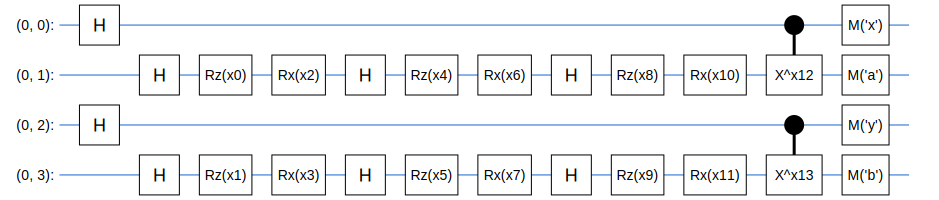

In [ ]:
param_symbols_no_ent = sympy.symbols('x0:14')
vqc_no_ent = build_vqc_no_ent(qubits, param_symbols_no_ent, add_measurement=True)
SVGCircuit(vqc_no_ent)

|   iter    |  target   |    x00    |    x01    |    x02    |    x03    |    x04    |    x05    |    x06    |    x07    |    x08    |    x09    |    x10    |    x11    |    x12    |    x13    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  2        |  0.4948   |  2.326    |  3.526    |  3.161    |  0.08651  |  4.856    |  5.546    |  2.293    |  3.867    |  0.4736   |  2.317    |  5.863    |  4.093    | -0.4112   |  1.155    |
|  4        |  0.558    |  0.2975   |  4.24     |  3.736    |  3.351    |  0.2722   |  3.528    |  2.071    |  3.16     |  0.7031   |  3.815    |  3.556    |  0.0425   |  0.4698   |  1.648    |
|  6        |  0.5712   |  4.64     |  3.69     |  2.963    |  0.6731   |  1.44     |  5.655    |  2.619    |  3.367    |  0.03901  |  1.889    |  2.745    |  3.846    |  1.673    |  0.5029   |
|  20       |  0.634    |  4.3

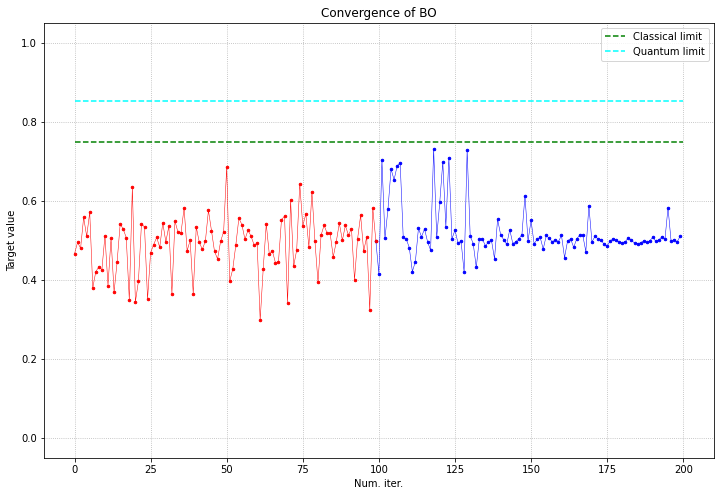

In [ ]:
pbounds_no_ent = {'x00': (0, 2 * np.pi), 'x01': (0, 2 * np.pi), 
                  'x02': (0, 2 * np.pi), 'x03': (0, 2 * np.pi),
                  'x04': (0, 2 * np.pi), 'x05': (0, 2 * np.pi),
                  'x06': (0, 2 * np.pi), 'x07': (0, 2 * np.pi),
                  'x08': (0, 2 * np.pi), 'x09': (0, 2 * np.pi),
                  'x10': (0, 2 * np.pi), 'x11': (0, 2 * np.pi),
                  'x12': (-2, 2), 'x13': (-2, 2)}

init_p = 100
iter = 100

optimizer_no_ent = BayesianOptimization(
    f=simulate_vqc_no_ent,
    pbounds=pbounds_no_ent,
    verbose=1,
    random_state=1234,
)

start = time()
optimizer_no_ent.maximize(
    init_points=init_p,
    acq='poi',
    #kappa=1,
    n_iter=iter,
)
end = time()

print(optimizer_no_ent.max)

print(f"\nTook {round((end - start)/ 60, 2)} m\n")

plot_target(optimizer_no_ent, init_p, iter)

As we can see we are not able to surpass the classical limit (except maybe for some noise in the simulation). The best we could achieve leads us to:

In [ ]:
best_params_no_ent = optimizer_no_ent.max["params"]
(x00, x01, x02, x03, x04, x05, x06, x07, x08, x09, x10, x11, x12, x13) = best_params_no_ent.values()

result_no_ent = simulate_vqc_no_ent(x00, x01, x02, x03, x04, x05, x06, x07, x08, x09, x10, x11, x12, x13)
print(f"Best result obtained (without entanglement): {result_no_ent}")

Best result obtained (without entanglement): 0.7304


## Entangling: on

Let's see what we can do if we let the circuit to build entanglement:

The circuit has been slightly modified: now there there are three CNOT gates (exponentiated to some parameter $\alpha_{i=\{1,2,3\}} \in [-2, 2]$) that are now able to generate entanglement between $|a\rangle$ and $|b\rangle$ and between $|x\rangle$ and $|y\rangle$.

An Hadamard gate (on $|a\rangle$) has been removed and that could be defined as "cheating".
It is possible to rework a (more complicated circuit) that achieves the same performance as this one but at the expense of an heavier optimization. 

This circuit can be seen as 1 layer of "Circuit 2" (proposed by https://arxiv.org/abs/1905.10876) preceeded by an Hadamard gate and followed by two CNOTs.

In [ ]:
def build_vqc(qubits, symbols, add_measurement=False):
    (x, a, y, b) = qubits
    circ = cirq.Circuit()
    circ.append([cirq.H(x), cirq.H(y)])

    circ.append([cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[0])(a), cirq.rz(symbols[1])(b)], 
                strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rx(symbols[2])(a), cirq.rx(symbols[3])(b)])
    circ.append([cirq.CX(b, a)**symbols[4]])

    circ.append([cirq.CX(x, a)**symbols[5], 
                 cirq.CX(y, b)**symbols[6]])

    if add_measurement:
        circ.append([cirq.measure(x, key='x'), cirq.measure(a, key='a'), 
                     cirq.measure(y, key='y'), cirq.measure(b, key='b')], 
                    strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    return circ

def simulate_vqc(x00, x01, x02, x03, x04, x05, x06):
    param_vals = (x00, x01, x02, x03, x04, x05, x06)
    param_res = cirq.ParamResolver({param_symbols[i] : param_vals[i] for i in range(len(param_vals))})
    sim_results = quant_simulator.run(vqc, param_res, repetitions=5000)
    df = sim_results.data.astype(np.bool)
    wins = (np.logical_and(df['x'], df['y']) == np.logical_xor(df['a'], df['b'])).astype(np.int8)
    win_pct = len(wins[wins == 1]) / len(wins)
    return win_pct

### Main execution

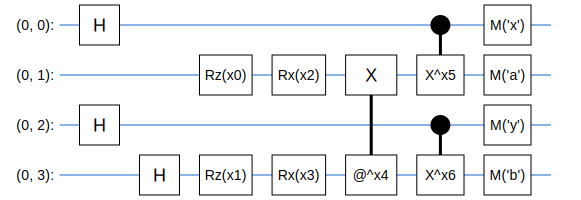

In [ ]:
param_symbols = sympy.symbols('x0:7')
vqc = build_vqc(qubits, param_symbols, add_measurement=True)
SVGCircuit(vqc)

|   iter    |  target   |    x00    |    x01    |    x02    |    x03    |    x04    |    x05    |    x06    |
-------------------------------------------------------------------------------------------------------------
|  22       |  0.745    |  0.8949   |  3.471    |  1.716    |  6.123    |  0.6711   | -0.9774   | -1.567    |
|  89       |  0.7484   |  3.826    |  6.211    |  1.408    |  3.69     |  1.34     |  1.17     | -0.6831   |
|  105      |  0.7538   |  4.324    |  3.014    |  5.504    |  4.073    | -1.062    |  0.1555   | -0.5697   |
|  109      |  0.8004   |  0.9417   |  3.507    |  1.866    |  6.082    |  0.7325   | -0.8397   | -1.468    |
|  129      |  0.8214   |  3.988    |  6.233    |  1.263    |  3.852    |  1.0      |  1.515    | -0.5564   |
|  138      |  0.83     |  3.892    |  6.225    |  1.3      |  3.846    |  1.057    |  1.493    | -0.6669   |
{'target': 0.83, 'params': {'x00': 3.8917123809312835, 'x01': 6.22473970630412, 'x02': 1.3000976566304139, 'x03': 3.8460

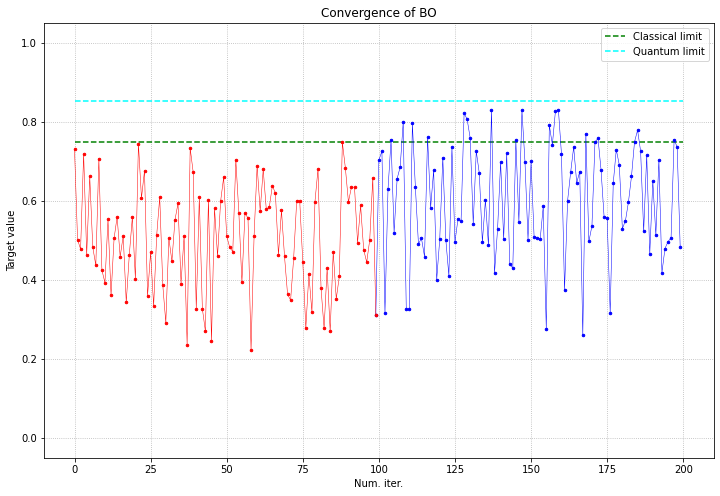

In [ ]:
pbounds = {'x00': (0, 2 * np.pi), 'x01': (0, 2 * np.pi), 
           'x02': (0, 2 * np.pi), 'x03': (0, 2 * np.pi),
           'x04': (-2, 2), 'x05': (-2, 2), 'x06': (-2, 2)}

init_p = 100
iter = 100

optimizer = BayesianOptimization(
    f=simulate_vqc,
    pbounds=pbounds,
    verbose=1,
    random_state=1234,
)

#logger = JSONLogger(path=datetime.now().strftime("logs_2_1_%d_%m_%Y_%H_%M_%S.json"))
#optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

start = time()
optimizer.maximize(
    init_points=init_p,
    acq='poi',
    #kappa=1,
    n_iter=iter,
)
end = time()

print(optimizer.max)

print(f"\nTook {round((end - start)/ 60, 2)} m\n")

plot_target(optimizer, init_p, iter)

And now we can see that the best result we can achieve is:

In [ ]:
best_params = optimizer.max["params"]
(x00, x01, x02, x03, x04, x05, x06) = best_params.values()

result_ent = simulate_vqc(x00, x01, x02, x03, x04, x05, x06)
print(f"Best result obtained (with entanglement): {result_ent}")

Best result obtained (with entanglement): 0.8174


A circuit with 7 parametrized gates and 3 Hadamards, along with a classical process of bayesian optimization, was able to guide us to a set of parameters that can demonstrate the violation of the bell inequality.